In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import sys
import math
import inspect
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils import data

# Preprocessing

In [0]:
#Create dictionary of file names for all devices.

In [250]:
# Following imports the data file
# NOTE: the NILM folder must be in YOUR drive not just shared with you
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

! cp '/content/gdrive/My Drive/NILM/Electricity_HPE.csv' 'Electricity_HPE.csv'
#! cp '/content/gdrive/My Drive/Cal/CS 182/NILM/Electricity_FGE.csv' 'Electricity_FGE.csv' # For Chester

Mounted at /content/gdrive


In [0]:
#For loop to create CSV objects for each device for future reference. 
filepath = '' #Currently, all CSV files are in my current working directory.
fridge = pd.read_csv(filepath + 'Electricity_HPE.csv')

In [260]:
"""
Create dataframes for every CSV file. This is where true preprocessing
happens.
"""
fridge_df = pd.DataFrame(fridge)
fridge_df = fridge_df[fridge_df['P'] < 2000] #remove power outliers
fridge_df.head(10)

,unix_ts,V,I,f,DPF,APF,P,Pt,Q,Qt,S,St
0,1333263600,235.3,0.4,60.0,0.99,0.70,36,360070,18,69353,52,382580
1,1333263660,236.0,0.4,60.0,0.99,0.72,37,360071,17,69353,52,382581
2,1333263720,235.3,0.4,60.0,0.99,0.72,38,360071,17,69353,53,382582
3,1333263780,235.5,0.4,60.0,0.99,0.70,37,360072,15,69354,53,382583
4,1333263840,235.5,0.4,60.0,0.99,0.68,36,360073,17,69354,53,382584
5,1333263900,235.6,0.4,60.0,0.99,0.71,36,360073,17,69354,51,382584
6,1333263960,235.3,0.4,60.0,0.99,0.72,37,360074,18,69355,52,382585
7,1333264020,235.6,0.4,60.0,0.99,0.73,37,360074,18,69355,51,382586
8,1333264080,235.1,0.4,60.0,0.99,0.72,37,360075,17,69355,52,382587
9,1333264140,235.2,0.4,60.0,0.99,0.71,36,360076,18,69355,51,382588


In [0]:
def get_2D_modes(df, metric, num_clusters):
    """
    Given a dataframe, find the modes corresponding to each
    unique setting. Threshold parameter is the +/- range we'll
    cluster values in. 
    """
    #Column name needs to be a string.
    assert isinstance(metric, str) 
    
    counts = df[metric].value_counts()
    unique = counts.index.values
    unique = unique.reshape(len(unique), 1)
    #unique.sort()
    #print(unique.flatten())
    clustering = KMeans(num_clusters).fit(unique)
    #print(clustering.labels_)
    
    #Now, we have all values in a particular "cluster", or mode. We need to find the center of the mode.
    counts_lst = counts.values
    cluster_keys = clustering.labels_ #for each unique metric value, what number cluster does it belong to?
    cluster_labels = set(cluster_keys) #all the cluster names
    num_clusters = len(cluster_labels) #total number of clusters
    cluster_freq = np.zeros(num_clusters)
    cluster_vals = np.zeros(num_clusters)
    
    for index, metric_value in enumerate(unique):
        cluster_num = cluster_keys[index] #get cluster number for specific metric value, i.e. cluster 0 for 118V
        if cluster_num == -1:
            pass
        cluster_freq[cluster_num] += counts_lst[index] #cluster_freq keeps track of number of values belonging to cluster_num
        cluster_vals[cluster_num] += metric_value*counts_lst[index] #used for averaging, to find center of cluster
    modes = cluster_vals / cluster_freq
    
    #print(cluster_vals)
    #We're not done yet. We have to one-hot encode now.
    #print(type(cluster_keys))
    metricValsToCluster = zip(unique, cluster_keys)
    #print(list(metricValsToCluster))
    #Generate dictionary because Python 3 doesn't allow dict(zip(...)) combination
    metricValsToClusterDict = {}
    for pair in list(metricValsToCluster):
        metricValsToClusterDict[pair[0][0]] = pair[1]
    #print(metricValsToClusterDict.keys())
    oneHotMatrix = np.zeros((num_clusters, df[metric].size))
    for index, val in enumerate(df[metric]):
        clusterValue = metricValsToClusterDict[val]
        oneHotMatrix[clusterValue][index] = 1
    return modes, oneHotMatrix

In [0]:
def get_1D_modes(fridge_df, metric, num_clusters):
    assert isinstance(metric, str) 
    
    power_data = fridge_df[metric]
    
    counts = power_data.value_counts()
    unique = counts.index.values
    unique = unique.reshape(len(unique), 1)
    flattened_unique = unique.flatten()

    clustering = KMeans(num_clusters).fit(unique)
    
    val_to_cluster = dict(zip(flattened_unique, clustering.labels_))
    
    power_data = np.array([val_to_cluster[x] for x in power_data])
    
    cluster_unique, cluster_counts = np.unique(power_data, return_counts=True)
    
    print(cluster_unique)
    print(cluster_counts)
    
    #print(np.sum(power_data) / len(power_data))
    
    return val_to_cluster.keys(), val_to_cluster.values()

In [0]:
def get_1D_modes_no_df(data, num_clusters):    
    power_data = data
    
    #counts = power_data.value_counts()
    #unique = counts.index.values
    unique, counts = np.unique(power_data, return_index=True)
    unique = unique.reshape(len(unique), 1)
    flattened_unique = unique.flatten()

    clustering = KMeans(num_clusters).fit(unique)
    
    val_to_cluster = dict(zip(flattened_unique, clustering.labels_))
    
    power_data = power_data['P'].values.flatten()
    
    power_data = np.array([val_to_cluster[x] for x in power_data])
    
    cluster_unique, cluster_counts = np.unique(power_data, return_counts=True)
    
    #print(cluster_unique)
    #print('pee')
    #print(cluster_counts)
    
    #print(np.sum(power_data) / len(power_data))
    
    # power_data is (a mapping from power value to) mode
    return power_data

In [264]:
"""
Here, I will cluster a specific column and find the modes, i.e.
find the voltage that correspond to the respective to each setting.
Example: 118V corresponds to an idle fridge, 130V corresponds to 
generating ice, 160V is to adjust temperature inside fridge, etc.
These numbers are purely made up. 
I'm not an EE expert, so I generalized this for any field, not just
voltage.
"""
metric = 'P'
fridge_modes, fridge_one_hot_encoded = get_1D_modes(fridge_df, metric, 2)

[0 1]
[ 69035 974230]


In [265]:
np.max(fridge_df['P'])

1999

In [266]:
fridge_one_hot_encoded

dict_values([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

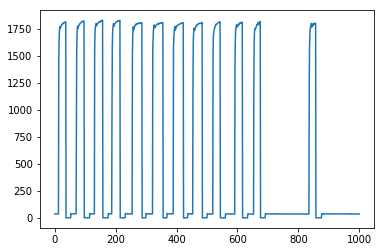

In [267]:
plt.plot(fridge_df[metric][:1000])
plt.show()

# LOADING DATA

In [0]:
from sklearn import preprocessing
master_data = fridge_df['P']
#master_data = preprocessing.scale(master_data)

In [0]:
def get_training_validation_and_testing(size_arr, percentage_arr, use_size=True):
  """
  Arguments:
  size_arr: pass in three values into an array corresponding to [num of training
    samples, num of validation samples, and num of test samples].
  percentage_arr: pass in four values for the percentage split of training/
    validation/test samples. Form: [percent training samples, percent validation
    samples, percent test samples, percent of all data to be used]
  use_size: flag to indicate whether to use the size_arr (True), otherwise use 
  percentage_arr (False)
  """
  if use_size:
    sum_of_all_data_needed = np.sum(size_arr)
    starting_index = np.random.randint(0, len(master_data) - sum_of_all_data_needed + 1)
    training = master_data[starting_index:starting_index + size_arr[0]]
    validation = master_data[starting_index + size_arr[0]:starting_index + size_arr[0] + size_arr[1]]
    test = master_data[starting_index + size_arr[0] + size_arr[1]:starting_index + sum_of_all_data_needed]
    return training.to_frame(), validation.to_frame(), test.to_frame()
  else:
    prop_training, prop_validation, prop_test, prop_total_data = percentage_arr
    #print(int(math.floor(len(master_data)*(1 - prop_total_data))))
    if prop_total_data == 1:
      starting_index = 0
    else:
      starting_index = np.random.randint(0, int(math.floor(len(master_data)*(1 - percentage_arr[3]))))
    data_subset = master_data[starting_index:starting_index + int(math.floor(len(master_data)))]
    training_endpoint = int(math.floor(len(data_subset)*percentage_arr[0]))
    training = data_subset[0:training_endpoint]
    validation_endpoint = int(math.floor(len(data_subset))*(percentage_arr[1])) + training_endpoint
    validation = data_subset[training_endpoint:validation_endpoint]
    test = data_subset[validation_endpoint:]
    return training.to_frame(), validation.to_frame(), test.to_frame()

In [0]:
class Dataset(data.Dataset):
  # Assumes full data fits into memory
  # From https://stanford.edu/~shervine/blog/pytorch-how-to-generate-data-parallel
  def __init__(self, samples, labels):
        # 'Initialization'
        new_labels = np.squeeze(np.asarray(labels))
        new_labels = new_labels[0:128, :]
        new_samples = np.zeros(new_labels.shape)
        print(new_samples.shape)
        idx = np.where(np.asarray(new_labels) > 100)
        new_samples[idx] = 1.0
        self.samples = new_samples #preprocessing.scale(new_samples)
        self.labels = new_labels

  def __len__(self):
        # 'Denotes the total number of samples'
        return len(self.labels)

  def __getitem__(self, index):
        # 'Generates one sample of data'
        # Select sample    
        X = self.samples[index]
#         X = self.samples[0]
#         X = preprocessing.scale(X)
        y = self.labels[index]
#         y = self.labels[0]

        return X, y

In [0]:
def extract_time_series(data, num_samples, time_series_length=500):
  jump = len(data) // (time_series_length * num_samples)
  time_serieses = []
  start_index = 0
  for _ in range(num_samples):
    time_serieses.append(data[start_index:start_index + time_series_length])
    start_index += jump
   
  return np.array(time_serieses)
  

In [0]:
def random_extract_time_series(data, num_samples, time_series_length=500):
  time_serieses = []
  for _ in range(num_samples):
    startingIndex = np.random.randint(0, len(data) - time_series_length + 1)
    time_serieses.append(data[startingIndex:startingIndex+time_series_length])
  return time_serieses
  

In [0]:
#print(len(master_data))
size_arr = [500, 300, 100]
percentage_arr = [0.7, 0.2, 0.1, 1]
training_labels, validation_labels, test_labels = get_training_validation_and_testing(size_arr, percentage_arr, False)

training_data = get_1D_modes_no_df(data=training_labels, num_clusters=2)
validation_data = get_1D_modes_no_df(data=validation_labels, num_clusters=2)
test_data = get_1D_modes_no_df(data=test_labels, num_clusters=2)

num_train_samples = 700000
num_validation_samples = 70
num_test_samples = 30

training_data = random_extract_time_series(training_data, num_train_samples)
validation_data = random_extract_time_series(validation_data, num_validation_samples)
test_data = random_extract_time_series(test_data, num_test_samples)
# training_data = np.reshape(training_data, (training_data.shape[0], 1)).astype(float)
# validation_data = np.reshape(validation_data, (validation_data.shape[0], 1)).astype(float)
# test_data = np.reshape(test_data, (test_data.shape[0], 1)).astype(float)

training_labels = random_extract_time_series(training_labels.values, num_train_samples)
validation_labels = random_extract_time_series(validation_labels.values, num_validation_samples)
test_labels = random_extract_time_series(test_labels.values, num_test_samples)

In [275]:
# Parameters
params = {'batch_size': 32,
          'shuffle': True,
          'num_workers': 2}

# Load in data
# https://pytorch.org/tutorials/beginner/data_loading_tutorial.html
print(len(training_data), len(training_labels))
#print(training_labels[:10])
training_set = Dataset(training_data, training_labels)
train_loader = data.DataLoader(training_set, **params)

params = {'batch_size': 6,
          'shuffle': True,
          'num_workers': 2}
validation_set = Dataset(validation_data, validation_labels)
val_loader = data.DataLoader(validation_set, **params)

params = {'batch_size': 6,
          'shuffle': True,
          'num_workers': 2}
test_set = Dataset(test_data, test_labels)
test_loader = data.DataLoader(test_set, **params)



700000 700000
(128, 500)
(70, 500)
(30, 500)


# MODEL

In [0]:
#helper to init layers
def init_layer(layer):
    """Initialize a Linear or Convolutional layer. """

    nn.init.xavier_uniform_(layer.weight)

#     if layer.weight.ndimension() == 4:
#         (n_out, n_in, height, width) = layer.weight.size()
#         n = n_in * height * width

#     elif layer.weight.ndimension() == 3:
#         (n_out, n_in, width) = layer.weight.size()
#         n = n_in * width

#     elif layer.weight.ndimension() == 2:
#         (n_out, n) = layer.weight.size()

#     std = math.sqrt(2. / n)
#     scale = std * math.sqrt(3.)
#     layer.weight.data.uniform_(-scale, scale)

#     if layer.bias is not None:
#         layer.bias.data.fill_(0.)

In [0]:
class Seq2Seq(nn.Module):

    def __init__(self, seq_len=15, to_binary=False):

        super(Seq2Seq, self).__init__()
        self.seq_len = seq_len
        self.to_binary = to_binary
        assert seq_len >= 10, f'seq_len ({seq_len}) must be at least 10'

        self.drop_layer = nn.Dropout(p=0.3)
        self.pad1 = nn.ReplicationPad2d((0, 0, 4, 5))
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=30, kernel_size=(10, 1), stride=(1, 1), padding=(0, 0), bias=True)
        self.conv1_bn = nn.BatchNorm2d(30)
        self.pad2 = nn.ReplicationPad2d((0, 0, 3, 4))
        self.conv2 = nn.Conv2d(in_channels=30, out_channels=30, kernel_size=(8, 1), stride=(1, 1), padding=(0, 0), bias=True)
        self.conv2_bn = nn.BatchNorm2d(30)
        self.pad3 = nn.ReplicationPad2d((0, 0, 2, 3))
        self.conv3 = nn.Conv2d(in_channels=30, out_channels=40, kernel_size=(6, 1), stride=(1, 1), padding=(0, 0), bias=True)
        self.conv3_bn = nn.BatchNorm2d(40)
        self.pad4 = nn.ReplicationPad2d((0, 0, 2, 2))
        self.conv4 = nn.Conv2d(in_channels=40, out_channels=50, kernel_size=(5, 1), stride=(1, 1), padding=(0, 0), bias=True)
        self.conv4_bn = nn.BatchNorm2d(50)
        self.pad5 = nn.ReplicationPad2d((0, 0, 2, 2))
        self.conv5 = nn.Conv2d(in_channels=50, out_channels=50, kernel_size=(5, 1), stride=(1, 1), padding=(0, 0), bias=True)
        self.conv5_bn = nn.BatchNorm2d(50)

        self.conv_final = nn.Conv2d(in_channels=50, out_channels=1, kernel_size=(1, 1), stride=(1, 1), padding=(0, 0), bias=True)

        self.init_weights()

    def init_weights(self):

        init_layer(self.conv1)
        init_layer(self.conv2)
        init_layer(self.conv3)
        init_layer(self.conv4)
        init_layer(self.conv5)
        init_layer(self.conv_final)

    def forward(self, data):

#         x = data.type('torch.cuda.FloatTensor')
        x = data
        x = x.view(x.shape[0], 1, x.shape[1], 1)

        #print(x.shape)
        x = self.pad1(x)
        #print(x.shape)
        x = F.relu(self.conv1_bn(self.conv1(x)))
        x = self.drop_layer(x)
        x = F.relu(self.conv2_bn(self.conv2(self.pad2(x))))
        x = self.drop_layer(x)
        x = F.relu(self.conv3_bn(self.conv3(self.pad3(x))))
        x = self.drop_layer(x)
        x = F.relu(self.conv4_bn(self.conv4(self.pad4(x))))
        x = self.drop_layer(x)
        x = F.relu(self.conv5_bn(self.conv5(self.pad5(x))))
        x = self.drop_layer(x)
#         x = F.relu(self.conv1(self.pad1(x)))
#         x = self.drop_layer(x)
#         x = F.relu(self.conv2(self.pad2(x)))
#         x = self.drop_layer(x)
#         x = F.relu(self.conv3(self.pad3(x)))
#         x = self.drop_layer(x)
#         x = F.relu(self.conv4(self.pad4(x)))
#         x = self.drop_layer(x)
#         x = F.relu(self.conv5(self.pad5(x)))
#         x = self.drop_layer(x)

        x = self.conv_final(x)
#         x = x.view(x.shape[0], x.shape[2])
        
        #print(x.shape)

        if self.to_binary:
            return torch.sigmoid(x)

        return x

In [0]:
# class SensibleSeq2Seq(nn.Module):

#     def __init__(self, seq_len=15, to_binary=False):

#         super(SensibleSeq2Seq, self).__init__()
#         self.seq_len = seq_len
#         self.to_binary = to_binary
#         assert seq_len >= 10, f'seq_len ({seq_len}) must be at least 10'

#         self.drop_layer = nn.Dropout(p=0.5)
#         #self.pad1 = nn.ReplicationPad2d((0, 0, 4, 5))
#         self.conv1 = nn.Conv2d(in_channels=1, out_channels=30, kernel_size=(10, 1), stride=(1, 1), padding=(0, 0), bias=False)
#         #self.conv1_bn = nn.BatchNorm2d(30)
#         #self.pad2 = nn.ReplicationPad2d((0, 0, 3, 4))
#         # we assume input is (500,1)
#         # in_features = out_channel * [(input_dim - kernel_size[0]) / stride + 1] * batch_size
#         self.linear1 = nn.Linear(14730 * batch_size, 1000, bias=False)
        
#         self.conv2 = nn.Conv2d(in_channels=30, out_channels=30, kernel_size=(8, 1), stride=(1, 1), padding=(0, 0), bias=False)
#         #self.conv2_bn = nn.BatchNorm2d(30)
#         #self.pad3 = nn.ReplicationPad2d((0, 0, 2, 3))
#         self.linear2 = nn.Linear(29790 * batch_size, 800, bias=False)

#         self.conv3 = nn.Conv2d(in_channels=30, out_channels=40, kernel_size=(6, 1), stride=(1, 1), padding=(0, 0), bias=False)
#         #self.conv3_bn = nn.BatchNorm2d(40)
#         #self.pad4 = nn.ReplicationPad2d((0, 0, 2, 2))
#         self.linear3 = nn.Linear(31800 * batch_size, 700, bias=False)
        
#         self.conv4 = nn.Conv2d(in_channels=40, out_channels=50, kernel_size=(5, 1), stride=(1, 1), padding=(0, 0), bias=False)
#         #self.conv4_bn = nn.BatchNorm2d(50)
#         #self.pad5 = nn.ReplicationPad2d((0, 0, 2, 2))
#         self.linear4 = nn.Linear(34800 * batch_size, 600, bias=False)
        
#         self.conv5 = nn.Conv2d(in_channels=50, out_channels=50, kernel_size=(5, 1), stride=(1, 1), padding=(0, 0), bias=False)
#         #self.conv5_bn = nn.BatchNorm2d(50)
#         self.linear5 = nn.Linear(19800 * batch_size, 500, bias=False)

#         self.conv_final = nn.Conv2d(in_channels=50, out_channels=1, kernel_size=(1, 1), stride=(1, 1), padding=(0, 0), bias=False)

#         self.init_weights()

#     def init_weights(self):

#         init_layer(self.conv1)
#         init_layer(self.conv2)
#         init_layer(self.conv3)
#         init_layer(self.conv4)
#         init_layer(self.conv5)
#         init_layer(self.conv_final)

#     def forward(self, data):

# #         x = data.type('torch.cuda.FloatTensor')
#         x = data
#         x = x.view(x.shape[0], 1, x.shape[1], 1)

#         x = F.relu(self.linear1(self.conv1(x)))
#         x = self.drop_layer(x)
#         x = F.relu(self.linear2(self.conv2(x)))
#         x = self.drop_layer(x)
#         x = F.relu(self.linear3(self.conv3(x)))
#         x = self.drop_layer(x)
#         x = F.relu(self.linear4(self.conv4(x)))
#         x = self.drop_layer(x)
#         x = F.relu(self.linear5(self.conv5(x)))
#         x = self.drop_layer(x)

#         x = self.conv_final(x)
# #         x = x.view(x.shape[0], x.shape[2])
#         if self.to_binary:
#             return torch.sigmoid(x)

#         return x

# TRAINING

In [0]:
# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
#cudnn.benchmark = True

learning_rate = 1e-2
num_epochs = 150

model = Seq2Seq().to(device)
# model = SensibleSeq2Seq().to(device)

# Use mean squared error loss
criterion =  nn.MSELoss() 

# Let's use Adam optimization algorithm
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Stepped LR
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.01)

# Lambda LR
# lr_lambda = lambda epoch: epoch * .95
# scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda, last_epoch=-1)

In [280]:
# Train the model
# Loop over epochs
print('Beginning training..')
total_step = len(train_loader)
training_loss_list = []
training_loss_step = []
validation_loss_list = []
validation_loss_epoch = []
total_step_taken = 0

for epoch in range(num_epochs):
    # Training
    print('epoch {}'.format(epoch + 1))
    for i, (local_batch,local_labels) in enumerate(train_loader):
        # Transfer to GPU
        local_ims, local_labels = local_batch.to(device=device, dtype=torch.float), local_labels.to(device=device, dtype=torch.float)
        
        # Forward pass
        outputs = model.forward(local_ims)
        local_labels = local_labels.reshape([32, 1, 500, 1])
        #print(outputs.shape, local_labels.shape)
        if i % 1000 == 0:  
          tmp_x  = np.squeeze(outputs.cpu().data.numpy()[0,:])
          tmp_y  = np.squeeze(local_labels.cpu().data.numpy()[0,:])
          tmp_in = np.squeeze(local_ims.cpu().data.numpy()[0,:]*50)
          plt.plot(tmp_x)
          plt.plot(tmp_y)
          plt.show()
#           print(np.squeeze(outputs[0]))
#           print(local_labels[0])
        loss = criterion(outputs, local_labels)
        if i % 1000 == 0:
          print(loss)
        # TODO: maintain a list of your losses as a function of number of steps
        #       because we ask you to plot this information
        # NOTE: if you use Google Colab's tensorboard-like feature to visualize
        #       the loss, you do not need to plot it here. just take a screenshot
        #       of the loss curve and include it in your write-up.

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_step_taken += 1
        
        # Uncomment below for changing learning rate
#         scheduler.step()

        if i % 1000 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
            training_loss_list.append(loss)
            training_loss_step.append(total_step_taken)
    if epoch % 10 == 0:
      validation_loss_list.append(run_validation())
      validation_loss_epoch.append(epoch)
    validation_loss_list.append(run_validation())
    validation_loss_epoch.append(epoch)

# print('Time: {}'.format(end - start))

Output hidden; open in https://colab.research.google.com to view.

Least Loss: tensor(5020.4248, device='cuda:0', grad_fn=<MseLossBackward>)


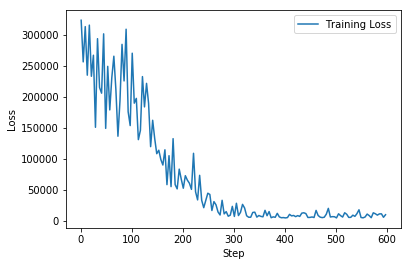

In [281]:
# Plot the training loss as a function of steps
plt.plot(training_loss_step, training_loss_list, label="Training Loss")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.legend()
print("Least Loss: " + str(min(training_loss_list)))

In [202]:
plt.savefig("Training_Loss.png")

<Figure size 432x288 with 0 Axes>

Least Loss: tensor(9601.7207, device='cuda:0')


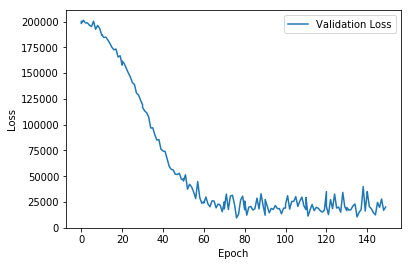

In [282]:
# Plot the training loss as a function of steps
plt.plot(validation_loss_epoch, validation_loss_list, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
print("Least Loss: " + str(min(validation_loss_list)))

In [204]:
plt.savefig("Validation_Loss.png")

<Figure size 432x288 with 0 Axes>

In [0]:
# Save the model to Google Drive
# torch.save(model.state_dict(), "/content/gdrive/My Drive/Cal/CS 182/NILM/" + 'model.ckpt') # For Chester
torch.save(model.state_dict(), "/content/gdrive/My Drive/NILM/" + 'seq2seq_lr5e-2_decay10g0.01_dropout0.5_ep50.ckpt') # For Andrew

In [206]:
# Load the model from Google Drive
model.load_state_dict(torch.load("/content/gdrive/My Drive/NILM/" + 'seq2seq_lr5e-2_decay10g0.01_dropout0.5_ep50.ckpt')) # For Andrew

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [0]:
# Validation
# In validation phase, we don't need to compute gradients (for memory efficiency)
def run_validation():
  print('Beginning Validation..')

  with torch.no_grad():
      correct = 0
      total = 0
      validation_losses = []
      for i,(local_batch,local_labels) in enumerate(val_loader):
          # Transfer to GPU
          local_ims, local_labels = local_batch.to(device=device, dtype=torch.float), local_labels.to(device=device, dtype=torch.float)

          outputs = model.forward(local_ims)
          first_dim = local_labels.shape[0]
          local_labels = local_labels.reshape([first_dim, 1, 500, 1])
          loss = criterion(outputs, local_labels)
          validation_losses.append(loss)

  #         _, predicted = torch.max(outputs.data, 1)

  #         total += local_labels.size(0)

  #         correct += (predicted == local_labels).sum().item()

  #     print('Accuracy of the network on the {} validation images: {} %'.format(total, 100 * correct / total))
  print(validation_losses)
  print(torch.mean(torch.stack(validation_losses)))
  return torch.mean(torch.stack(validation_losses))

In [283]:
# Testing
# Final test phase
print('Beginning Test..')

with torch.no_grad():
    correct = 0
    total = 0
    test_losses = []
    for i,(local_batch,local_labels) in enumerate(test_loader):
        # Transfer to GPU
        local_ims, local_labels = local_batch.to(device=device, dtype=torch.float), local_labels.to(device=device, dtype=torch.float)

        outputs = model.forward(local_ims)
        first_dim = local_labels.shape[0]
        local_labels = local_labels.reshape([first_dim, 1, 500, 1])
        loss = criterion(outputs, local_labels)
        test_losses.append(loss)
        
print(test_losses)
print(torch.mean(torch.stack(test_losses)))
print(torch.min(torch.stack(test_losses)))

Beginning Test..
[tensor(33646.2070, device='cuda:0'), tensor(51231.0664, device='cuda:0'), tensor(7638.7754, device='cuda:0'), tensor(22996.4805, device='cuda:0'), tensor(5150.8525, device='cuda:0')]
tensor(24132.6777, device='cuda:0')
tensor(5150.8525, device='cuda:0')
